In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Defining transformations
transform = transforms.Compose([
    transforms.Resize(64),  
    transforms.CenterCrop((64, 64)),  
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(root=r"C:\Users\Paras Vichoray\Downloads\QCNN_facial_recognition\face_recog_data\training-data", transform=transform)
test_data = datasets.ImageFolder(root=r"C:\Users\Paras Vichoray\Downloads\QCNN_facial_recognition\face_recog_data\test-data", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

class_names = train_data.classes
print(class_names)  # ['person1', 'person2']

['Gruhit', 'Paras']


In [2]:
import pennylane as qml
from pennylane import numpy as np

# Number of qubits and layers in the quantum circuit
n_qubits = 4
n_layers = 2

dev = qml.device("default.qubit", wires=n_qubits)

# Quantum Circuit
@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=True)
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Defining the quantum node in PennyLane
weight_shapes = {"weights": (n_layers, n_qubits, 3)}
quantum_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class QuantumCNN(nn.Module):
    def __init__(self):
        super(QuantumCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 16)
        self.quantum_layer = quantum_layer

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))

        # Quantum part of the model
        x = self.quantum_layer(x)
        
        return x

In [4]:
# Training
model = QuantumCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 50
for epoch in range(n_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/50, Loss: 1.1126543696110065
Epoch 2/50, Loss: 1.0224224466543932
Epoch 3/50, Loss: 0.9188666733411642
Epoch 4/50, Loss: 0.8321661215562087
Epoch 5/50, Loss: 0.7963531934298002
Epoch 6/50, Loss: 0.770022261601228
Epoch 7/50, Loss: 0.7522403850005224
Epoch 8/50, Loss: 0.7340707549682031
Epoch 9/50, Loss: 0.7198413289510287
Epoch 10/50, Loss: 0.7078972504689143
Epoch 11/50, Loss: 0.6975784164208633
Epoch 12/50, Loss: 0.6881528450892522
Epoch 13/50, Loss: 0.6805847539351537
Epoch 14/50, Loss: 0.6721493853972509
Epoch 15/50, Loss: 0.6656571328639984
Epoch 16/50, Loss: 0.6600404335902288
Epoch 17/50, Loss: 0.6540246376624475
Epoch 18/50, Loss: 0.6497747439604539
Epoch 19/50, Loss: 0.6446982667996333
Epoch 20/50, Loss: 0.64084592461586
Epoch 21/50, Loss: 0.637459051150542
Epoch 22/50, Loss: 0.6327789907272046
Epoch 23/50, Loss: 0.6295675314389743
Epoch 24/50, Loss: 0.625252386698356
Epoch 25/50, Loss: 0.6217833574001606
Epoch 26/50, Loss: 0.6180136295465323
Epoch 27/50, Loss: 0.61443

In [5]:
# Saving the trained model
model_save_path = 'quantum_cnn_model_2.pth'
torch.save(model.state_dict(), model_save_path)

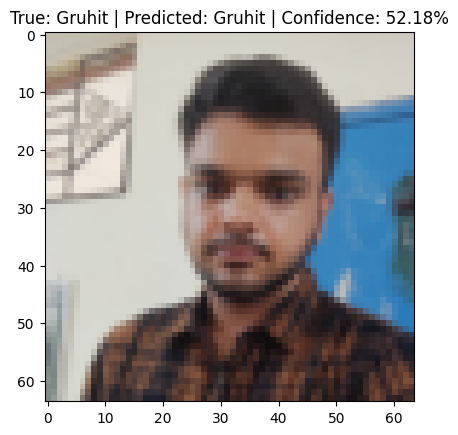

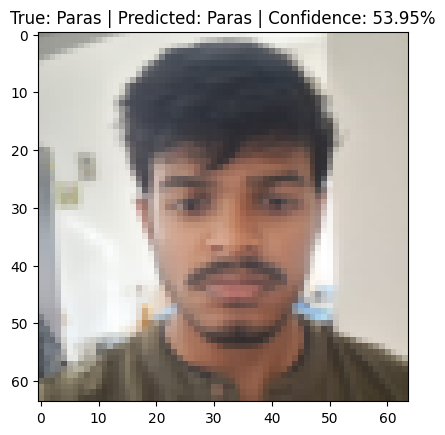


Overall Accuracy: 100.00%


In [6]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()

    image = image.numpy().transpose((1, 2, 0))
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    if title:
        ax.set_title(title)
    plt.pause(0.001)
    return ax

def predict_person_and_display(model, test_loader, class_names):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            confidence, predicted_idx = torch.max(probabilities, 1)
            predicted_name = class_names[predicted_idx.item()]

            # Checking if prediction is correct
            correct += (predicted_idx == labels).sum().item()
            total += len(labels)

            true_name = class_names[labels.item()]
            accuracy = confidence.item() * 100

            image_tensor = inputs.squeeze(0)
            imshow(image_tensor, title=f"True: {true_name} | Predicted: {predicted_name} | Confidence: {accuracy:.2f}%")

    overall_accuracy = 100 * correct / total
    print(f"\nOverall Accuracy: {overall_accuracy:.2f}%")

predict_person_and_display(model, test_loader, class_names)